In [1]:
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt
import matplotlib as matl
import os
import tweepy
import pandas as pd
import numpy as np
import re
from  tqdm import tqdm
from langdetect import detect
import string
import nltk.data
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import WordNetLemmatizer
from collections import defaultdict
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('words')
import datetime
!pip install empath
from empath import Empath
!pip install textblob
import textblob as tb

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\potta\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\potta\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\potta\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\potta\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


In [2]:
def load_data_fromfile(file):
    data = pd.read_csv(file,sep=',',encoding='utf8')
    return data

def fetch_file_fromdir(directory):
    df = pd.DataFrame({'tweet' : []})
    for file_path in tqdm(os.listdir(directory),desc=os.path.basename(directory)):
        df1 = load_data_fromfile(os.path.join(directory, file_path))
        df = pd.concat([df,df1],sort=True).reset_index(drop=True,)
    return df

def load_dataset(directory):
    train_df = fetch_file_fromdir(os.path.join(os.getcwd(),directory))
    return train_df

def Dateformatter(df):
    for index,row in df.iterrows():
        try:
            df.loc[index,'Date'] = pd.to_datetime(row['Date'])
        except:
            df.drop(index,inplace=True)
    return df    

In [3]:
tweet_df = load_dataset()
tweet_df.drop('Unnamed: 0',axis=1,inplace=True)
tweet_df = Dateformatter(tweet_df)
#tweet_df.tweet_id = tweet_df.tweet_id.astype('uint64')

Data: 100%|██████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00,  9.34it/s]


## Removing non-English

In [4]:
def distill_english(text):
    try:
        op = detect(text)
    except:
        op = 'ran'
    return op

In [5]:
tweet_df = tweet_df[tweet_df.apply(lambda x: distill_english(x['tweet'])=='en', axis=1)]

In [6]:
tweet_df.reset_index(drop=True)
tweet_df.loc[:,'location'] = tweet_df.loc[:,'location'].str.lower()
tweet_df.to_csv('englishtweet.csv')

In [8]:
tweet_df = pd.read_csv('englishtweet.csv')
tweet_df.drop('Unnamed: 0',axis=1,inplace=True)
tweet_df

,Date,hashtags,location,sentiment,tweet,tweet_id
0,2020-03-20 04:25:15+00:00,NaN,NaN,0.040000,RT @crissles: if i really had corona last year...,1.240857e+18
1,2020-03-19 21:38:08+00:00,NaN,united states,0.000000,RT @zairfulradzuan: everyone coming out of cor...,1.240754e+18
2,2020-03-20 04:11:47+00:00,NaN,united states,0.200000,"RT @Gordough_: Corona Virus isn't real, the go...",1.240854e+18
3,2020-03-20 02:04:30+00:00,NaN,ghana,0.000000,RT @ChazCapps: I can’t believe my future child...,1.240821e+18
4,2020-03-19 21:41:38+00:00,TrumpVirus,eritrea,-0.187500,RT @tmorello: Sprinkle a little racism on the ...,1.240755e+18
...,...,...,...,...,...,...
129083,2020-04-03 18:30:02+00:00,StayHomeStaySafe,india,-0.125000,@MrJograna @CMOGuj @vibhavaridave @saurabhpate...,1.246143e+18
129084,2020-04-04 01:15:16+00:00,NaN,NaN,0.500000,The issue of insurance companies covering hosp...,1.246245e+18
129085,2020-04-04 05:40:28+00:00,NaN,NaN,0.214286,NCDC una jst de smart oh. If not be corona nob...,1.246312e+18
129086,2020-04-04 03:54:29+00:00,NaN,united states,0.375000,@MSNBC @TheLastWord Wow! While everyone is try...,1.246285e+18


## Which Countries standout

In [9]:
MaxtweetedCountries = tweet_df['location'].value_counts()[:5].index.tolist()
MaxtweetedCountries

['united states', 'india', 'nigeria', 'pakistan', 'ghana']

In [10]:
Countries_tweetcount = tweet_df.groupby('location')['tweet_id'].count()
Countries_tweetcount[Countries_tweetcount > 1000]

location
argentina          1620
canada             1277
chile              1051
eritrea            1304
ghana              2034
india             17030
kenya              1113
malaysia           1012
nigeria            3992
pakistan           2193
south africa       1578
united kingdom     1181
united states     20710
Name: tweet_id, dtype: int64

## Countries News

In [241]:
!pip install newsapi-python
from newsapi import NewsApiClient
newsapi = NewsApiClient(api_key='e1515df61abb49ecb045c060cb829fcf')

In [242]:
MaxtweetedCountries

['united states', 'india', 'nigeria', 'ghana', 'pakistan']

In [246]:
 newsapi.get_everything(qintitle = 'lockdown india',
                                      from_param='2020-04-03',
                                      to='2020-05-03',
                                      language='en',
                                      sort_by='relevancy',
                                      page=1,
                                      page_size=1)

{'status': 'ok',
 'totalResults': 1136,
 'articles': [{'source': {'id': 'bbc-news', 'name': 'BBC News'},
   'author': 'https://www.facebook.com/bbcnews',
   'title': 'Coronavirus: India lockdown extended for two more weeks',
   'description': "The country's major cities will remain under strict restrictions, with some relaxation elsewhere.",
   'url': 'https://www.bbc.co.uk/news/world-asia-india-52505436',
   'urlToImage': 'https://ichef.bbci.co.uk/news/1024/branded_news/7839/production/_112077703_31466597-2b1a-4cf1-8f04-29c364b7b194.jpg',
   'publishedAt': '2020-05-01T13:52:12Z',
   'content': 'Image copyrightAFPImage caption\r\n There are fears for vulnerable members of communities amid severe economic disruption\r\nThe national coronavirus lockdown in India has been extended beyond 4 May for another two weeks.\r\nNew guidelines, outlined on Friday, upda… [+632 chars]'}]}

In [264]:
events = []
for i in MaxtweetedCountries:
    w = newsapi.get_everything(qintitle = 'lockdown'+' '+str(i),from_param='2020-04-03',to='2020-05-03',language='en',sort_by='relevancy',page=1)['articles'][0]
    events.append(w)

In [291]:
events[1]['title']

'Coronavirus: India lockdown extended for two more weeks'

## countries data distribution

In [136]:
US_tweet_df = pd.read_csv('englishtweet.csv')
US_tweet_df = US_tweet_df[US_tweet_df['location'] == 'united states']
US_tweet_df.drop('Unnamed: 0',axis=1,inplace=True)
print(US_tweet_df.shape)
UK_tweet_df = pd.read_csv('englishtweet.csv')
UK_tweet_df = UK_tweet_df[UK_tweet_df['location'] == 'united kingdom']
UK_tweet_df.drop('Unnamed: 0',axis=1,inplace=True)
print(UK_tweet_df.shape)
IN_tweet_df = pd.read_csv('englishtweet.csv')
IN_tweet_df = IN_tweet_df[IN_tweet_df['location'] == 'india']
IN_tweet_df.drop('Unnamed: 0',axis=1,inplace=True)
print(IN_tweet_df.shape)
NG_tweet_df = pd.read_csv('englishtweet.csv')
NG_tweet_df = NG_tweet_df[NG_tweet_df['location'] == 'nigeria']
NG_tweet_df.drop('Unnamed: 0',axis=1,inplace=True)
print(NG_tweet_df.shape)

(20710, 6)
(1181, 6)
(17030, 6)
(3992, 6)


In [103]:
print(NG_tweet_df.shape)

(3992, 6)


## Countries Death Curve

In [53]:
covid_df = pd.read_csv('owid-covid-data.csv')

In [22]:
covid_df[covid_df['location'].str.lower()=='switzerland'][covid_df['week']=='Week 12']

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,iso_code,location,date,total_cases,new_cases,total_deaths,new_deaths,total_cases_per_million,new_cases_per_million,total_deaths_per_million,...,aged_70_older,gdp_per_capita,extreme_poverty,cvd_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_100k,week
3388,CHE,Switzerland,2020-03-16,2200,841,13,2,254.200,97.174,1.502,...,12.644,57410.166,NaN,99.739,5.59,22.6,28.9,NaN,4.53,Week 12
3389,CHE,Switzerland,2020-03-17,2200,0,14,1,254.200,0.000,1.618,...,12.644,57410.166,NaN,99.739,5.59,22.6,28.9,NaN,4.53,Week 12
3390,CHE,Switzerland,2020-03-18,2650,450,19,5,306.195,51.995,2.195,...,12.644,57410.166,NaN,99.739,5.59,22.6,28.9,NaN,4.53,Week 12
3391,CHE,Switzerland,2020-03-19,3010,360,21,2,347.791,41.596,2.426,...,12.644,57410.166,NaN,99.739,5.59,22.6,28.9,NaN,4.53,Week 12
3392,CHE,Switzerland,2020-03-20,3888,878,33,12,449.240,101.449,3.813,...,12.644,57410.166,NaN,99.739,5.59,22.6,28.9,NaN,4.53,Week 12
3393,CHE,Switzerland,2020-03-21,4840,952,43,10,559.239,109.999,4.968,...,12.644,57410.166,NaN,99.739,5.59,22.6,28.9,NaN,4.53,Week 12


In [3]:
def WeekifyTweet(df):
    for index, row in tqdm(df.iterrows(), total=df.shape[0]):
        #print(index)
        try:            
            date = row['date']
            #print(date)
            if date >= '2020-03-16' and date < '2020-03-22':
                df.loc[index,'week'] = 'Week 12'
            elif date >= '2020-03-23' and date <= '2020-03-29':
                df.loc[index,'week'] = 'week_13'
            elif date >= '2020-03-30' and date <= '2020-04-05':
                df.loc[index,'week'] = 'week_14'
            elif date >= '2020-04-06' and date <= '2020-04-12':
                df.loc[index,'week'] = 'week_15'
            elif date >= '2020-04-13' and date <= '2020-04-19':
                df.loc[index,'week'] = 'week_16'    
            elif date >= '2020-04-20' and date <= '2020-04-26':
                df.loc[index,'week'] = 'week_17'
            elif date >= '2020-04-27' and date <= '2020-05-03':
                df.loc[index,'week'] = 'week_18'
            elif date >= '2020-05-04' and date <= '2020-05-10':
                df.loc[index,'week'] = 'week_19'
            elif date >= '2020-05-11' and date <= '2020-05-17':
                df.loc[index,'week'] = 'week_20'       
            elif date >= '2020-05-18' and date <= '2020-05-24':
                df.loc[index,'week'] = 'week_21'   
            elif date >= '2020-05-25' and date <= '2020-05-31':
                df.loc[index,'week'] = 'week_22'  
            else:
                df.loc[index,'week'] = 'not_needed' 
        except:           
            df.drop(index,inplace=True)   
    #print(df.head())                                                       
    return df


In [54]:
covid_df = WeekifyTweet(covid_df)


100%|███████████████████████████████████████████████████████████████████████████| 20556/20556 [00:43<00:00, 473.12it/s]


In [62]:
mask = pd.Series(covid_df['week']=='not_needed')

In [63]:
covid_df.location = covid_df.location.str.lower()
covid_df = covid_df[~mask]
covid_df.to_csv('covid-data.csv')

In [43]:
countries_covid_stat = covid_df.groupby(['location','week']).sum()

In [46]:
countries_covid_stat.reset_index(level=0,inplace=True)
countries_covid_stat[countries_covid_stat['location']=='India']

,index,week,location,total_cases,new_cases,total_deaths,new_deaths,total_cases_per_million,new_cases_per_million,total_deaths_per_million,...,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cvd_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_100k
1047,1047,Week 12,India,942,141,19,2,0.682,0.102,0.013,...,35.934,20.484,38560.044,127.2,1693.68,62.34,11.4,123.6,357.30,3.18
1048,1048,not_needed,India,959,179,9,2,0.689,0.129,0.006,...,455.164,259.464,488427.224,1611.2,21453.28,789.64,144.4,1565.6,4525.80,40.28
1049,1049,week_13,India,4718,659,99,21,3.419,0.477,0.072,...,41.923,23.898,44986.718,148.4,1975.96,72.73,13.3,144.2,416.85,3.71
1050,1050,week_14,India,14261,2395,347,52,10.334,1.736,0.251,...,41.923,23.898,44986.718,148.4,1975.96,72.73,13.3,144.2,416.85,3.71
1051,1051,week_15,India,41631,4982,1249,196,30.167,3.610,0.905,...,41.923,23.898,44986.718,148.4,1975.96,72.73,13.3,144.2,416.85,3.71
1052,1052,week_16,India,86810,7356,2862,234,62.905,5.332,2.074,...,41.923,23.898,44986.718,148.4,1975.96,72.73,13.3,144.2,416.85,3.71
1053,1053,week_17,India,151321,10784,4771,317,109.652,7.814,3.457,...,41.923,23.898,44986.718,148.4,1975.96,72.73,13.3,144.2,416.85,3.71
1054,1054,week_18,India,234068,13484,7553,477,169.614,9.772,5.474,...,41.923,23.898,44986.718,148.4,1975.96,72.73,13.3,144.2,416.85,3.71
1055,1055,week_19,India,370252,22959,12394,808,268.297,16.637,8.982,...,41.923,23.898,44986.718,148.4,1975.96,72.73,13.3,144.2,416.85,3.71
1056,1056,week_20,India,549029,27988,17736,763,397.846,20.282,12.853,...,41.923,23.898,44986.718,148.4,1975.96,72.73,13.3,144.2,416.85,3.71


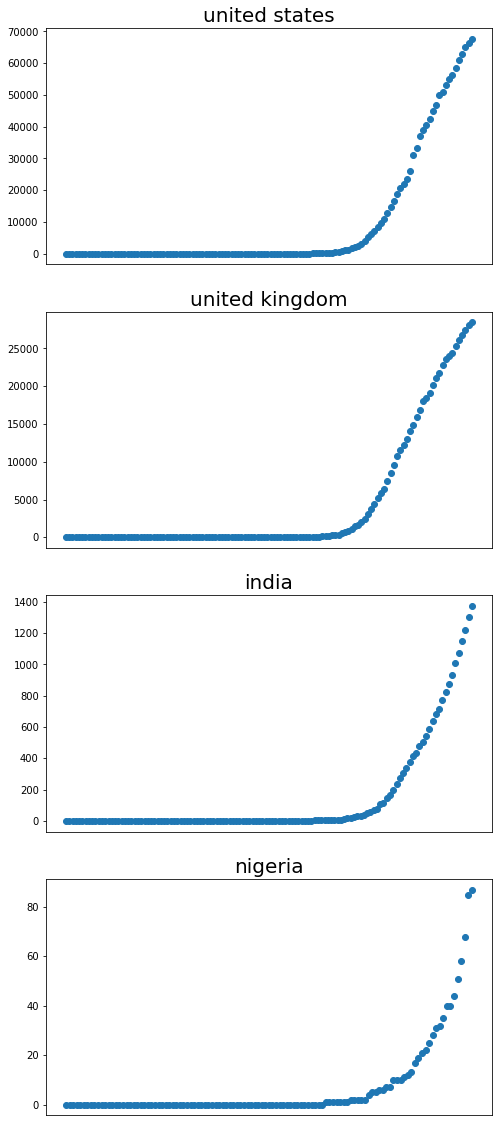

In [13]:
Countries_needed = ['united states','united kingdom','india','nigeria']
fig, axes = plt.subplots(nrows=4,ncols=1,figsize=(8,20))
j=0
for i in Countries_needed:
    DC_df = covid_df[covid_df['location'].str.lower() == str(i)][['date','total_deaths']]
    axes[j].plot_date(DC_df['date'], DC_df['total_deaths'],xdate=True)
    axes[j].set_title(i,fontsize=20)
    axes[j].get_xaxis().set_visible(False)
    j+=1

In [41]:
covid_df['date'].values

array(['2020-03-13', '2020-03-20', '2020-03-24', ..., '2020-03-01',
       '2020-03-02', '2020-03-10'], dtype=object)

In [53]:
covid_df[covid_df['date'].isin(Date_list)][covid_df['location'].str.lower() == 'nigeria']

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,iso_code,location,date,total_cases,new_cases,total_deaths,new_deaths,total_cases_per_million,new_cases_per_million,total_deaths_per_million,new_deaths_per_million,total_tests,new_tests,total_tests_per_thousand,new_tests_per_thousand,tests_units
10358,NGA,Nigeria,2020-03-19,8,5,0,0,0.039,0.024,0.000,0.000,NaN,NaN,NaN,NaN,NaN
10359,NGA,Nigeria,2020-03-20,8,0,0,0,0.039,0.000,0.000,0.000,NaN,NaN,NaN,NaN,NaN
10360,NGA,Nigeria,2020-03-21,12,4,0,0,0.058,0.019,0.000,0.000,NaN,NaN,NaN,NaN,NaN
10361,NGA,Nigeria,2020-03-22,22,10,0,0,0.107,0.049,0.000,0.000,NaN,NaN,NaN,NaN,NaN
10362,NGA,Nigeria,2020-03-23,30,8,0,0,0.146,0.039,0.000,0.000,NaN,NaN,NaN,NaN,NaN
10363,NGA,Nigeria,2020-03-24,40,10,1,1,0.194,0.049,0.005,0.005,NaN,NaN,NaN,NaN,NaN
10364,NGA,Nigeria,2020-03-25,44,4,1,0,0.213,0.019,0.005,0.000,NaN,NaN,NaN,NaN,NaN
10365,NGA,Nigeria,2020-03-26,51,7,1,0,0.247,0.034,0.005,0.000,NaN,NaN,NaN,NaN,NaN
10366,NGA,Nigeria,2020-03-27,65,14,1,0,0.315,0.068,0.005,0.000,NaN,NaN,NaN,NaN,NaN
10367,NGA,Nigeria,2020-03-28,81,16,1,0,0.393,0.078,0.005,0.000,NaN,NaN,NaN,NaN,NaN


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys


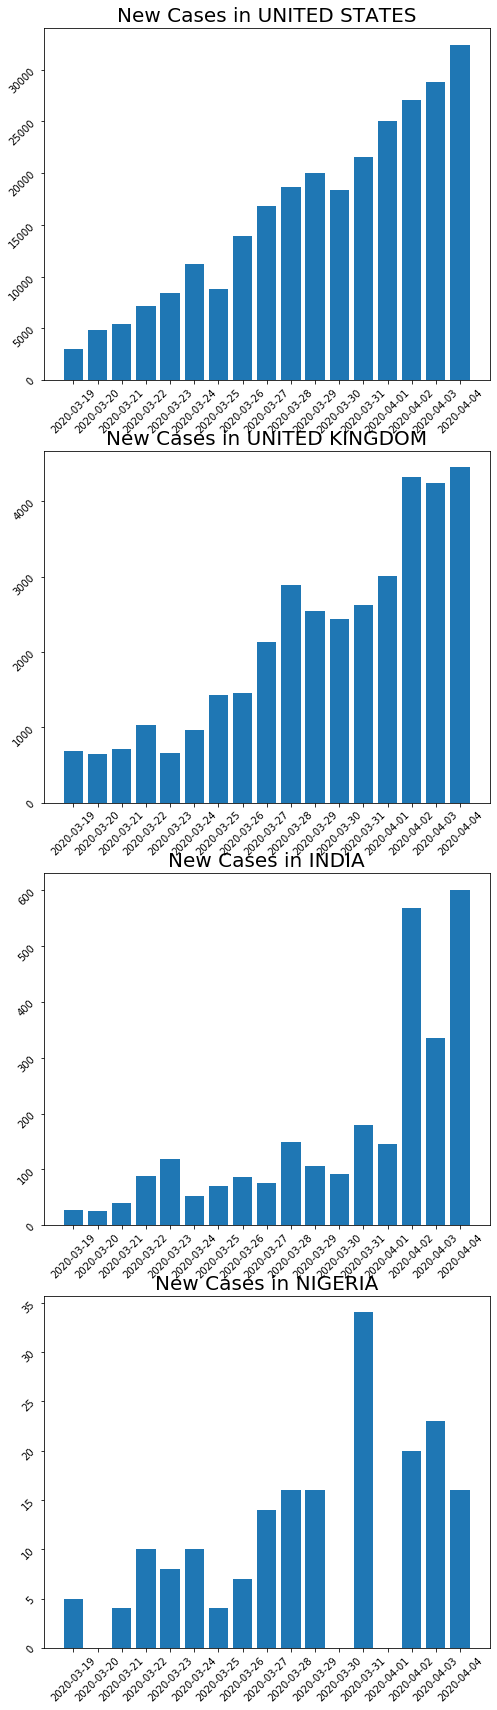

In [84]:
Countries_needed = ['united states','united kingdom','india','nigeria']
Date_list = tweet_df.Date.map(lambda x: str(x).split()[0])
fig, axes = plt.subplots(nrows=4,ncols=1,figsize=(8,12))
plt.subplots_adjust(top=2)
j=0
for i in Countries_needed:
    DC_df = covid_df[covid_df['location'].str.lower() == str(i)][ covid_df['date'].isin(Date_list) ][['date','new_cases']].reset_index(drop=True)
    axes[j].bar(DC_df['date'], DC_df['new_cases'])
    axes[j].set_title('New Cases in '+i.upper(),fontsize=20)
    axes[j].tick_params(labelrotation=45)
    j+=1

In [2]:
from tqdm import tqdm

lst = [1,2,3,4,5,6]

for i in tqdm(lst):
    print(i)

  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

1
2
3
4
5
6


100%|███████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 334.27it/s]


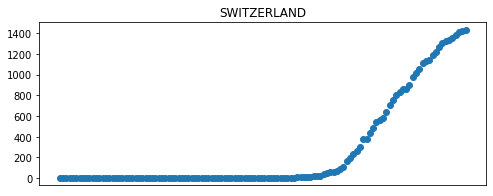

In [288]:
fig , ax = plt.subplots(figsize=(8,3))
DC_df = covid_df[covid_df['location'].str.lower() == str('switzerland')][['date','total_deaths']]
ax.plot_date(DC_df['date'], DC_df['total_deaths'],xdate=True)
ax.set_title('SWITZERLAND')
ax.get_xaxis().set_visible(False)

## Countries Details

## Topic Modeling

In [152]:
tm_tweet_df = pd.read_csv('englishtweet.csv')


## Cleaning the Tweet from unneccessary words

In [85]:
def clean_tweets(tweet):
    stop_words = set(STOPWORDS)
    alphabets = set(string.ascii_lowercase)
    tweet = tweet.lower()
    #after tweet preprocessing the colon symbol left remain
    tweet = re.sub(r'‚Ä¶', '', tweet)
    #replacing the user tagging 
    tweet = re.sub(r'@([^\s]+)', ' ', tweet)
    #replace the URLs
    tweet = re.sub(r'http[s]?[:]?[\s]?\/\/(?:[a-z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-f][0-9a-f]))+',' ',tweet)
    #replace the n't
    tweet = re.sub(r'n\'t', ' not', tweet)
    #replace the 's'
    tweet = re.sub(r'\'s', '', tweet)
    #replace the numbers
    tweet = re.sub(r'\d', '', tweet)
    #replace the dots
    tweet = re.sub(r'…', '', tweet)

    exclude = set(string.punctuation).union(set(['’','…','``','...','“','‘','”']))

    word_tokens = word_tokenize(tweet)
    #filter using NLTK library append it to a string
    filtered_tweet = [w for w in word_tokens]
    filtered_tweet = []
    #looping through conditions
    for w in word_tokens:
    #check tokens against stop words and punctuations
        if w not in exclude and w not in ('rt','…',) and w not in stop_words and w not in alphabets:
            filtered_tweet.append(w)
    return ' '.join(filtered_tweet)

In [154]:
tm_tweet_df.tweet = classified_df.tweet.map(clean_tweets)

In [155]:
texts = [word_tokenize(tm_tweet_df['tweet'][i]) for i,row in tm_tweet_df.iterrows()]
texts

[['really',
  'corona',
  'last',
  'year',
  'really',
  'think',
  'trust',
  'yall',
  'want',
  'shit',
  'especially',
  'now'],
 ['everyone', 'coming', 'corona', 'barista'],
 ['corona',
  'virus',
  'real',
  'government',
  'wants',
  'everyone',
  'inside',
  'two',
  'weeks',
  'change',
  'batteries',
  'bir'],
 ['believe',
  'future',
  'child',
  'one',
  'day',
  'going',
  'write',
  'dbq',
  'corona',
  'virus'],
 ['sprinkle',
  'little',
  'racism',
  'problem',
  'maybe',
  'will',
  'help',
  'trumpvirus'],
 ['day', 'rediscovered', 'farming'],
 ['close',
  'president',
  'notes',
  'seen',
  'crossed',
  'corona',
  '``',
  'replaced',
  'chinese',
  '``',
  'virus'],
 ['corona',
  'shit',
  'passes',
  'promise',
  're',
  'going',
  'tell',
  'kids',
  'survived',
  'zombie',
  'apoc'],
 ['day', 'rediscovered', 'farming'],
 ['ok',
  'mind',
  'got',
  'ta',
  'ask',
  'corona',
  'jokes',
  'ok',
  'others',
  'aren',
  'people',
  'seem',
  'take',
  'pretty',
  'l

In [156]:
frequency = defaultdict(int)
for text in texts:
    for token in text:
        frequency[token] += 1
frequency

defaultdict(int,
            {'really': 1207,
             'corona': 53752,
             'last': 1248,
             'year': 731,
             'think': 1188,
             'trust': 101,
             'yall': 164,
             'want': 2101,
             'shit': 3126,
             'especially': 144,
             'now': 3807,
             'everyone': 2395,
             'coming': 735,
             'barista': 297,
             'virus': 20823,
             'real': 1445,
             'government': 1613,
             'wants': 704,
             'inside': 799,
             'two': 1066,
             'weeks': 1746,
             'change': 694,
             'batteries': 522,
             'bir': 516,
             'believe': 447,
             'future': 556,
             'child': 87,
             'one': 3234,
             'day': 2429,
             'going': 2766,
             'write': 55,
             'dbq': 1,
             'sprinkle': 5,
             'little': 355,
             'racism': 90,
             

In [157]:
texts = [[token for token in text if frequency[token] >= 20] for text in texts]

In [158]:
!pip install gensim
import gensim
import gensim.corpora as corpora
from gensim import corpora
from collections import defaultdict
from gensim import models
from gensim import similarities

In [1]:
#First created a mapping for words and some index value
dictionary = corpora.Dictionary(texts)
#Below we are taking the Frequency of the each word as per the word's assigned index value above
corpus = [dictionary.doc2bow(text) for text in texts]
# Training LDA Model
lda_model = models.ldamodel.LdaModel(corpus=corpus,id2word=dictionary,
                                           num_topics=10, 
                                           random_state=42,
                                           update_every=1,
                                           chunksize=200,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

NameError: name 'corpora' is not defined

## Topics in the Tweets

In [160]:
lda_model.print_topics(num_words=4)

[(0,
  '0.051*"officially" + 0.038*"positive" + 0.026*"chinesevirus" + 0.016*"back"'),
 (1, '0.067*"now" + 0.043*"``" + 0.043*"one" + 0.037*"boris"'),
 (2, '0.069*"will" + 0.040*"amp" + 0.040*"week" + 0.038*"world"'),
 (3, '0.374*"corona" + 0.137*"virus" + 0.037*"today" + 0.029*"yesterday"'),
 (4, '0.138*"government" + 0.065*"telling" + 0.049*"real" + 0.048*"two"'),
 (5, '0.052*"days" + 0.043*"us" + 0.031*"go" + 0.025*"said"'),
 (6, '0.230*"want" + 0.134*"name" + 0.099*"love" + 0.098*"calling"'),
 (7, '0.170*"coronavirus" + 0.118*"india" + 0.083*"shit" + 0.068*"going"'),
 (8, '0.065*"people" + 0.032*"home" + 0.028*"please" + 0.027*"entire"'),
 (9, '0.070*"due" + 0.056*"three" + 0.046*"cases" + 0.040*"covid"')]

In [161]:
corpal_list = [token for text in texts for token in text]
corpal_string = " ".join(corpal_list)

In [162]:
wc = WordCloud(background_color="white", max_words=50, random_state=1,max_font_size=40).generate(corpal_string)

## Word Cloud

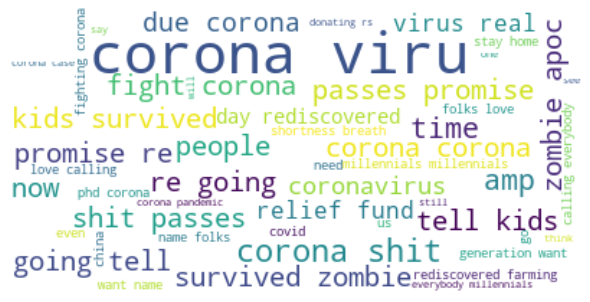

In [163]:
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wc,interpolation="bilinear") 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show() 

## word cloud for individual country

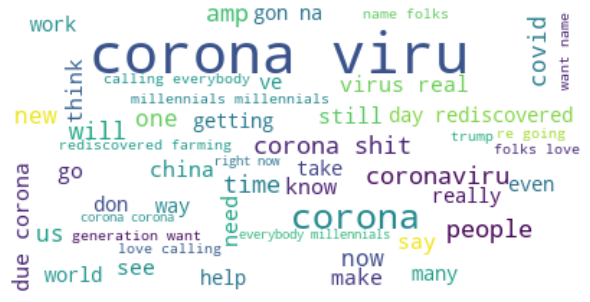

In [86]:
US_tweet_df.tweet = US_tweet_df.tweet.map(clean_tweets)
texts = [word_tokenize(US_tweet_df['tweet'][i]) for i,row in US_tweet_df.iterrows()]
corpal_list = [token for text in texts for token in text]
corpal_string = " ".join(corpal_list)
wc = WordCloud(background_color="white", max_words=50, random_state=1,max_font_size=40).generate(corpal_string)
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wc,interpolation="bilinear") 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show() 

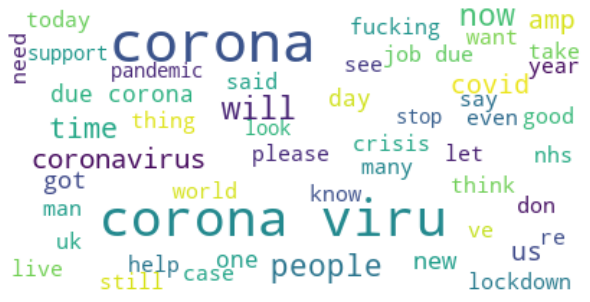

In [87]:
UK_tweet_df.tweet = UK_tweet_df.tweet.map(clean_tweets)
texts = [word_tokenize(UK_tweet_df['tweet'][i]) for i,row in UK_tweet_df.iterrows()]
corpal_list = [token for text in texts for token in text]
corpal_string = " ".join(corpal_list)
wc = WordCloud(background_color="white", max_words=50, random_state=1,max_font_size=40).generate(corpal_string)
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wc,interpolation="bilinear") 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show() 

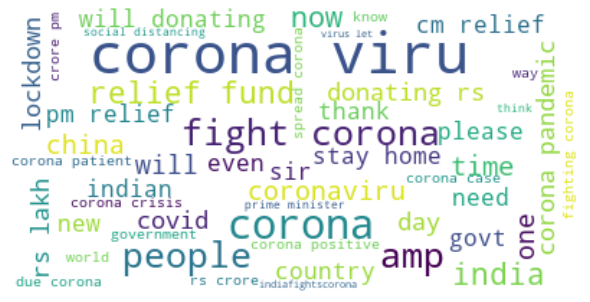

In [90]:
IN_tweet_df.tweet = IN_tweet_df.tweet.map(clean_tweets)
texts = [word_tokenize(IN_tweet_df['tweet'][i]) for i,row in IN_tweet_df.iterrows()]
corpal_list = [token for text in texts for token in text]
corpal_string = " ".join(corpal_list)
wc = WordCloud(background_color="white", max_words=50, random_state=1,max_font_size=40).generate(corpal_string)
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wc,interpolation="bilinear") 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show() 

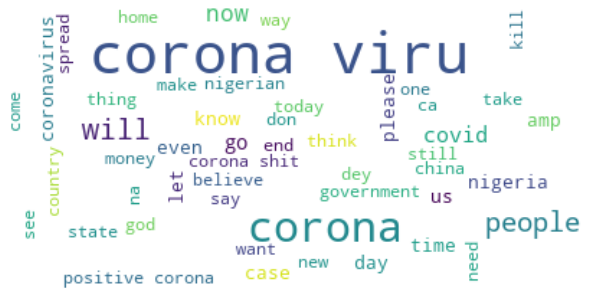

In [88]:
NG_tweet_df.tweet = NG_tweet_df.tweet.map(clean_tweets)
texts = [word_tokenize(NG_tweet_df['tweet'][i]) for i,row in NG_tweet_df.iterrows()]
corpal_list = [token for text in texts for token in text]
corpal_string = " ".join(corpal_list)
wc = WordCloud(background_color="white", max_words=50, random_state=1,max_font_size=40).generate(corpal_string)
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wc,interpolation="bilinear") 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show() 

## Lexicon Sentiment Analysis

In [165]:
lsa_tweet_df = tweet_df
Empath().analyze(lsa_tweet_df.loc[2,'tweet'])

{'help': 0.0,
 'office': 0.0,
 'dance': 0.0,
 'money': 1.0,
 'wedding': 0.0,
 'domestic_work': 0.0,
 'sleep': 0.0,
 'medical_emergency': 0.0,
 'cold': 0.0,
 'hate': 0.0,
 'cheerfulness': 0.0,
 'aggression': 0.0,
 'occupation': 0.0,
 'envy': 0.0,
 'anticipation': 0.0,
 'family': 0.0,
 'vacation': 0.0,
 'crime': 0.0,
 'attractive': 0.0,
 'masculine': 0.0,
 'prison': 0.0,
 'health': 0.0,
 'pride': 0.0,
 'dispute': 0.0,
 'nervousness': 0.0,
 'government': 1.0,
 'weakness': 0.0,
 'horror': 0.0,
 'swearing_terms': 0.0,
 'leisure': 0.0,
 'suffering': 0.0,
 'royalty': 0.0,
 'wealthy': 0.0,
 'tourism': 0.0,
 'furniture': 0.0,
 'school': 0.0,
 'magic': 0.0,
 'beach': 0.0,
 'journalism': 0.0,
 'morning': 0.0,
 'banking': 0.0,
 'social_media': 0.0,
 'exercise': 0.0,
 'night': 0.0,
 'kill': 0.0,
 'blue_collar_job': 0.0,
 'art': 0.0,
 'ridicule': 0.0,
 'play': 0.0,
 'computer': 0.0,
 'college': 0.0,
 'optimism': 0.0,
 'stealing': 0.0,
 'real_estate': 0.0,
 'home': 0.0,
 'divine': 0.0,
 'sexual': 0.0

In [166]:
def categorizeLexiconWords(df):
    cat = ["positive_emotion","negative_emotion","hate","joy","fun","horror","fear","sadness","anger","pain"]
    d = {el:0 for el in cat}
    for index,row in df.iterrows():
        derdict = Empath().analyze(row['tweet'], categories=cat)
        d = {k: d.get(k) + derdict.get(k) for k in set(d)}
    return d
emotioncatdict = categorizeLexiconWords(lsa_tweet_df)

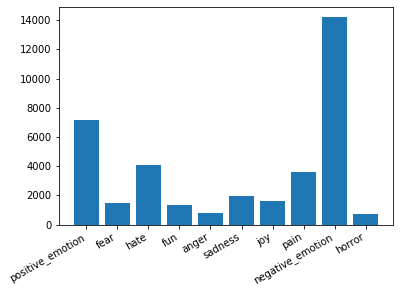

In [167]:
plt.bar(emotioncatdict.keys(),emotioncatdict.values())
plt.xticks(rotation=30, ha='right')
plt.show()

## Lexicon Sentiment Analysis for country

In [98]:
lsa_tweet_df = NG_tweet_df
Empath().analyze(lsa_tweet_df.loc[2,'tweet'])

KeyError: 2

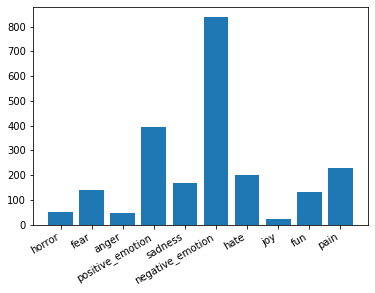

In [99]:
def categorizeLexiconWords(df):
    cat = ["positive_emotion","negative_emotion","hate","joy","fun","horror","fear","sadness","anger","pain"]
    d = {el:0 for el in cat}
    for index,row in df.iterrows():
        derdict = Empath().analyze(row['tweet'], categories=cat)
        d = {k: d.get(k) + derdict.get(k) for k in set(d)}
    return d
emotioncatdict = categorizeLexiconWords(lsa_tweet_df)
plt.bar(emotioncatdict.keys(),emotioncatdict.values())
plt.xticks(rotation=30, ha='right')
plt.show()

In [168]:
freq_list = [WordNetLemmatizer().lemmatize(i) for i in list(frequency)]

cat = ["positive_emotion","negative_emotion","hate","joy","fun","horror","fear","sadness","anger","pain"]
catdict = {el:[] for el in cat}
for w in freq_list:
    derdict = Empath().analyze(w, categories=cat)
    for key,value in catdict.items():
        if derdict[key] > 0:
            value.append(w)
catdict

{'positive_emotion': ['trust',
  'feeling',
  'love',
  'keep',
  'great',
  'care',
  'family',
  'friend',
  'friend',
  'wish',
  'honestly',
  'hope',
  'better',
  'happy',
  'joy',
  'enthusiasm',
  'respect',
  'closure',
  'reason',
  'keep',
  'proud',
  'emotion',
  'family',
  'faith',
  'overjoyed',
  'kindness',
  'freedom',
  'trust',
  'loyalty',
  'honest',
  'feeling',
  'concern',
  'glad',
  'happiness',
  'reason',
  'loved',
  'forgiveness',
  'gratitude',
  'assurance',
  'thrill',
  'assurance',
  'pride',
  'closure',
  'love',
  'surprise',
  'care',
  'hope',
  'convince',
  'sincere',
  'alive',
  'trusting',
  'comfort',
  'bond',
  'honesty',
  'surprise',
  'bond',
  'forgiving',
  'wish',
  'concern',
  'genuine',
  'understanding',
  'dearly',
  'comfort',
  'confidence',
  'enlighten',
  'reassurance',
  'accomplishment',
  'rejoice',
  'empathy',
  'curiosity',
  'certainty',
  'respect',
  'compassion',
  'cherish',
  'faith',
  'reunite',
  'freedom'

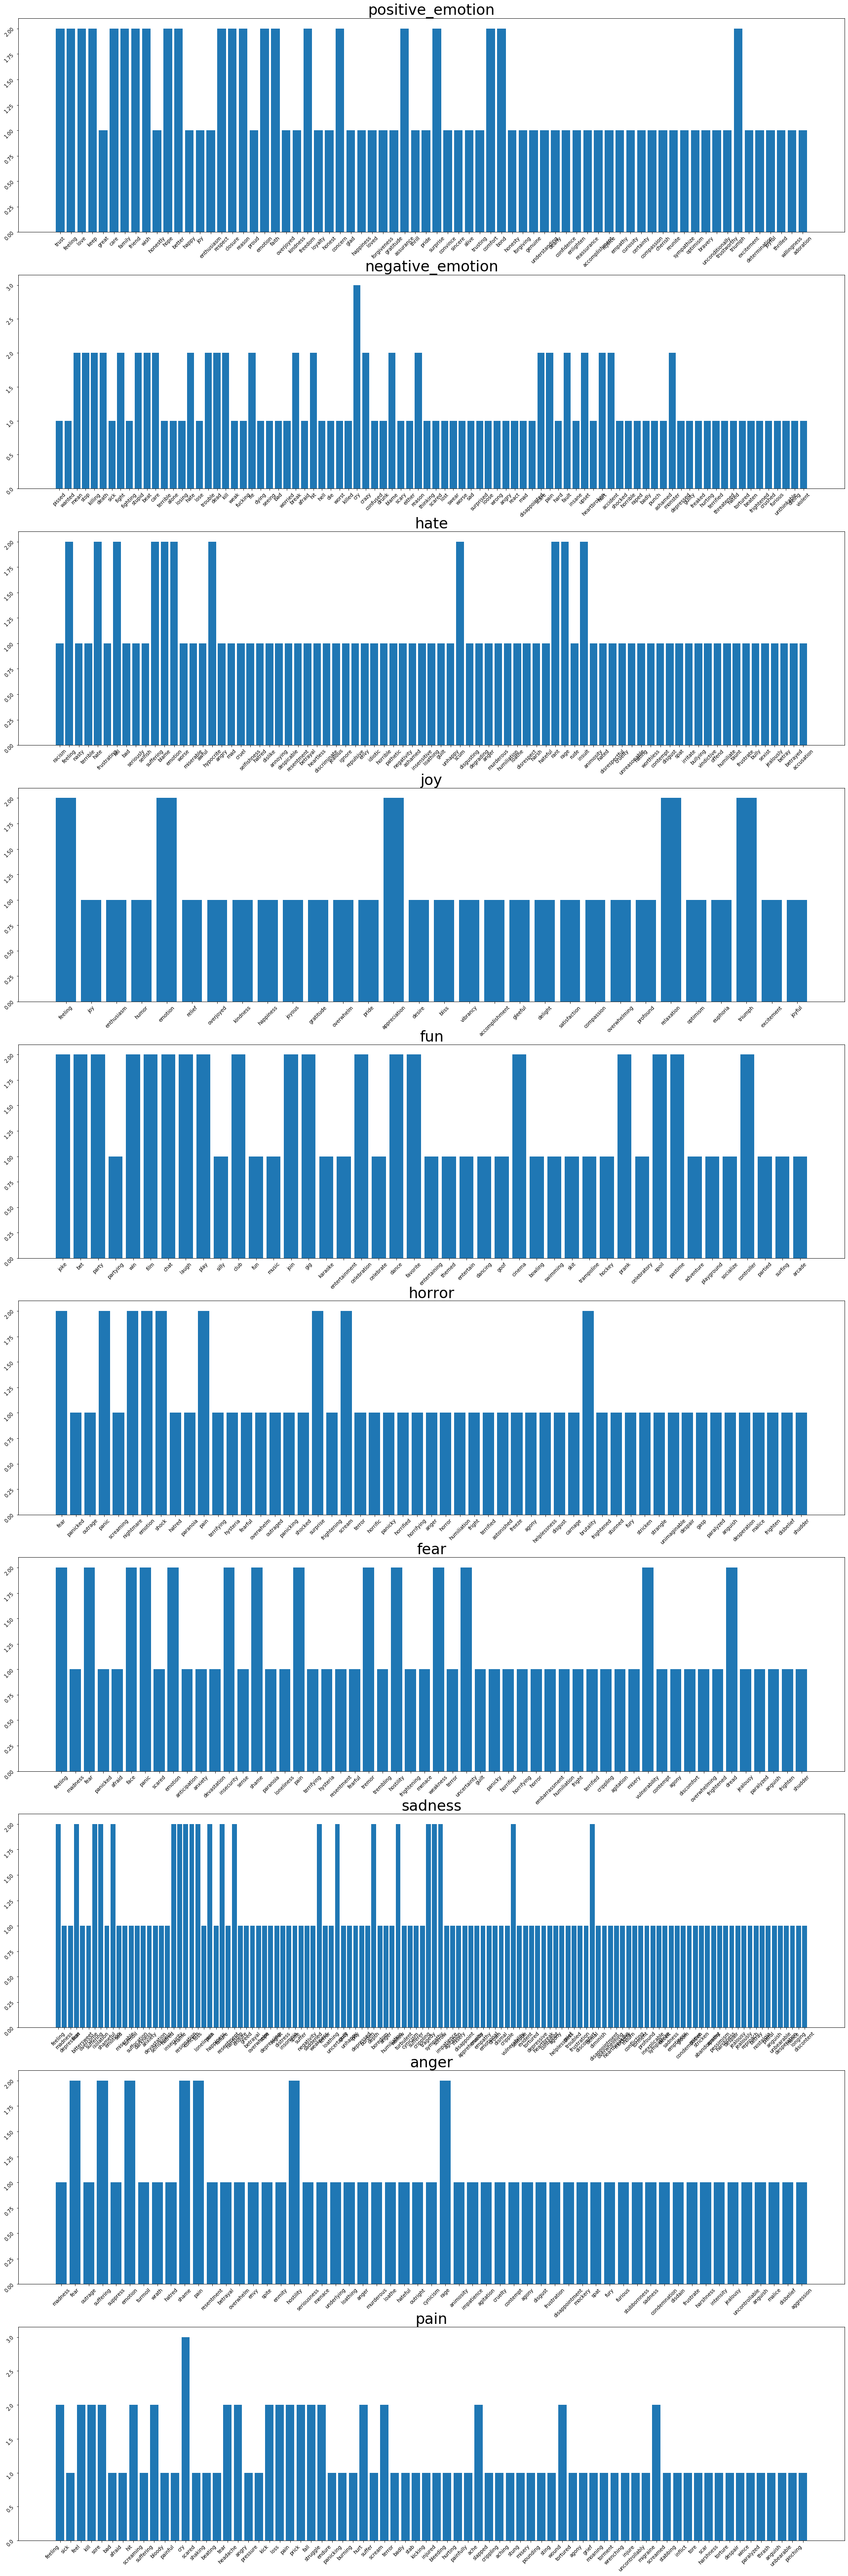

In [186]:
from collections import Counter
fig,ax =plt.subplots(nrows=10,ncols=1,sharex=False, sharey= False, figsize=(30,40),)
plt.subplots_adjust(top=1.9)
def makeplot(k,lst,i):
    cdict = dict(Counter(lst))
    ax[i].bar(cdict.keys(),cdict.values(),)
    ax[i].tick_params(labelrotation=45)
    ax[i].set_title(k,fontsize=30)
    return True
i=0
for k in catdict.keys():
    makeplot(k,catdict[k],i)
    i+=1
plt.xticks(rotation=45, ha='right')
plt.show()

In [187]:
# tb.TextBlob('corona').sentiment

Sentiment(polarity=0.0, subjectivity=0.0)

In [188]:
# derdict = {'positive_emotion': 0.0, 'negative_emotion': 0.0, 'hate': 1.0, 'joy': 0.0, 'fun': 0.0, 'horror': 0.0, 'fear': 0.0, 'sadness': 0.0, 'anger': 0.0, 'pain': 0.0}
# catdict = {el:[] for el in cat}
# for k,v in catdict.items():
#     if derdict[k] > 0 :
#         print(v.append(w))
# catdict

None


{'positive_emotion': [],
 'negative_emotion': [],
 'hate': ['cities/rivers/seas'],
 'joy': [],
 'fun': [],
 'horror': [],
 'fear': [],
 'sadness': [],
 'anger': [],
 'pain': []}

## Analysis based on Time interval

In [137]:
US_tweet_df.Date

1         2020-03-19 21:38:08+00:00
2         2020-03-20 04:11:47+00:00
5         2020-03-20 01:42:18+00:00
7         2020-03-20 01:03:15+00:00
10        2020-03-19 20:46:36+00:00
                    ...            
129037    2020-04-03 09:10:24+00:00
129046    2020-04-03 22:41:07+00:00
129065    2020-04-03 10:50:16+00:00
129067    2020-04-03 10:40:46+00:00
129086    2020-04-04 03:54:29+00:00
Name: Date, Length: 20710, dtype: object

In [138]:
US_tweet_df.Date = US_tweet_df['Date'].map(lambda x :pd.to_datetime(x,dayfirst=True))

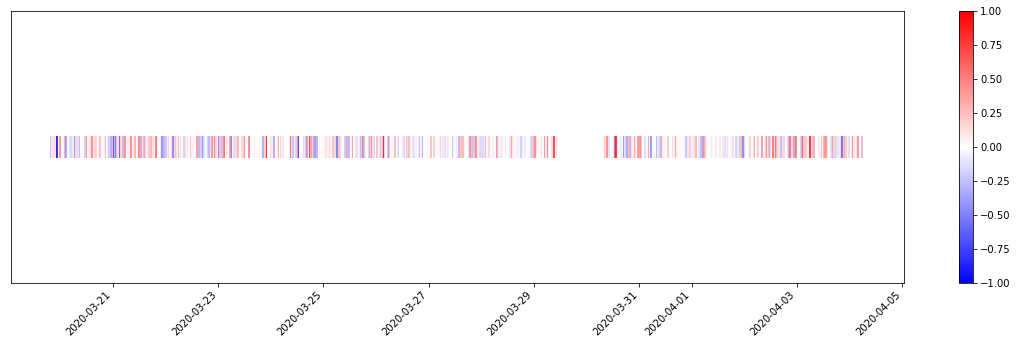

In [146]:
import matplotlib.dates as mdates
#myFmt = mdates.DateFormatter('%x%X')
fig ,axes = plt.subplots()
y = np.ones(np.shape(tweet_df.Date))   # Make all y values the same
ys = plt.scatter(tweet_df.Date,y,c=tweet_df.sentiment,cmap='bwr',marker='|',s=500)
axcb = fig.colorbar(ys)
#ax.set_title('Line Collection with mapped colors')
fig.set_size_inches(20,5)
axes.get_yaxis().set_visible(False)
#axes.xaxis.set_major_formatter(myFmt)
plt.xticks(rotation=45, ha='right')
plt.show()

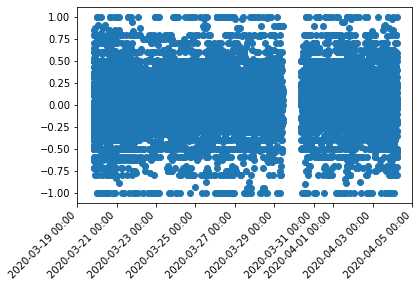

In [159]:
from matplotlib.dates   import  DateFormatter,AutoDateLocator
plt.scatter(US_tweet_df.Date,US_tweet_df.sentiment)
#ax.set_title('Line Collection with mapped colors')
fig.set_size_inches(80,10)
plt.gca().set_xlim( '2020-03-19', '2020-04-05' )
plt.gca().xaxis.set_major_locator(   AutoDateLocator() )
plt.gca().xaxis.set_major_formatter( DateFormatter( '%Y-%m-%d %H:%M' ) ) 
plt.gcf().autofmt_xdate()
plt.xticks(rotation=45, ha='right')
plt.show()

In [157]:
US_tweet_df.Date

1        2020-03-19 21:38:08+00:00
2        2020-03-20 04:11:47+00:00
5        2020-03-20 01:42:18+00:00
7        2020-03-20 01:03:15+00:00
10       2020-03-19 20:46:36+00:00
                    ...           
129037   2020-04-03 09:10:24+00:00
129046   2020-04-03 22:41:07+00:00
129065   2020-04-03 10:50:16+00:00
129067   2020-04-03 10:40:46+00:00
129086   2020-04-04 03:54:29+00:00
Name: Date, Length: 20710, dtype: datetime64[ns, UTC]

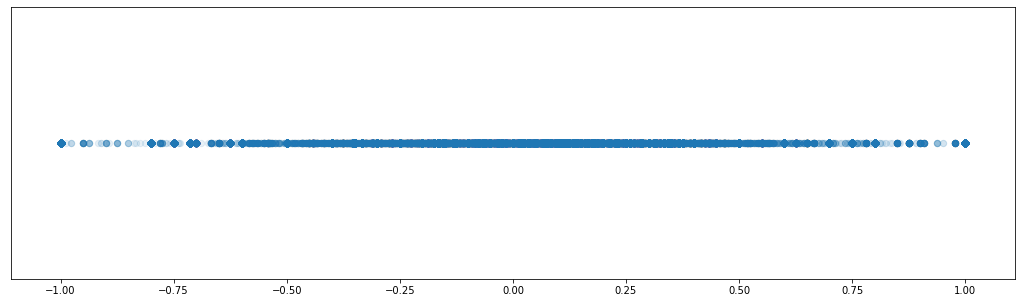

In [192]:
fig ,axes = plt.subplots()
plt.scatter(tweet_df.sentiment,y,s=40,alpha=0.1)
fig.set_size_inches(18,5)
axes.get_yaxis().set_visible(False)
plt.show()

## Analysis on only Means

In [224]:
Mean_df = pd.read_csv('englishtweet.csv')
Mean_df.drop('Unnamed: 0',axis=1,inplace=True)
Mean_df.Date = Mean_df.Date.map(lambda x: str(x).split()[0])
Mean_df

,Date,hashtags,location,sentiment,tweet,tweet_id
0,2020-03-20,NaN,NaN,0.040000,RT @crissles: if i really had corona last year...,1.240857e+18
1,2020-03-19,NaN,united states,0.000000,RT @zairfulradzuan: everyone coming out of cor...,1.240754e+18
2,2020-03-20,NaN,united states,0.200000,"RT @Gordough_: Corona Virus isn't real, the go...",1.240854e+18
3,2020-03-20,NaN,ghana,0.000000,RT @ChazCapps: I can’t believe my future child...,1.240821e+18
4,2020-03-19,TrumpVirus,eritrea,-0.187500,RT @tmorello: Sprinkle a little racism on the ...,1.240755e+18
...,...,...,...,...,...,...
80432,2020-03-27,NaN,NaN,0.000000,OHHHHH THERES A CORONA VIRUS CASE AT 10 DOWNIN...,1.243499e+18
80433,2020-03-27,NaN,india,-0.168000,Italy:\nTotal Corona Case (TCC): 80589\nRecove...,1.243643e+18
80434,2020-03-28,NaN,NaN,-0.016667,RT @fawadchaudhry: You are a journo not an ord...,1.243783e+18
80435,2020-03-27,coronavirus,united states,0.258333,Some good news as the world quickly conducts h...,1.243566e+18


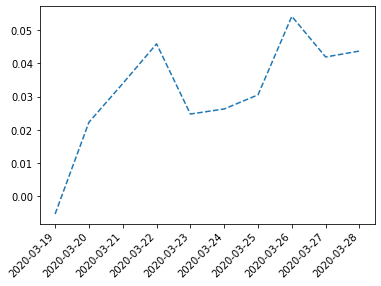

In [226]:
Mean_df = Mean_df.groupby('Date')
Mean = Mean_df['sentiment'].mean()
plt.plot(Mean,linestyle='--')
plt.xticks(rotation=45, ha='right')
plt.show()

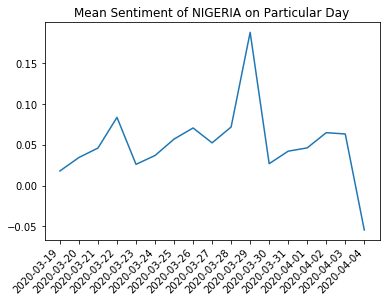

In [122]:
Mean_df = NG_tweet_df
#Mean_df.drop('Unnamed: 0',axis=1,inplace=True)
Mean_df.Date = Mean_df.Date.map(lambda x: str(x).split()[0])
Mean_df = Mean_df.groupby('Date')
Mean = Mean_df['sentiment'].mean()
plt.plot(Mean)
plt.xticks(rotation=45, ha='right')
plt.title('Mean Sentiment of NIGERIA on Particular Day')
plt.show()

## Sentiment Analysis for work

In [123]:
def removal_nonwork_tweet(text):
    op=0
    patterns=re.compile(r'[\b]?work[\b]?|[\b]?remotework[\b]?|[\b]?business[\b]?|[\b]?job[\b]?|[\b]?project[\b]?|[\b]?homeoffice[\b]?|[\b]?ofc[\b]?|[\b]?wrk[\b]?|[\b]?remotelife[\b]?|[\b]?mycoworkers[\b]?|[\b]?telecommute[\b]?|[\b]?homebusiness[\b]?|[\b]?homebusiness[\b]?|[\b]?freelance[\b]?|[\b]?companies[\b]?|[\b]?productivity[\b]?|[\b]?digitalnomad[\b]?|[\b]?goremote[\b]?|[\b]?laptoplifestyle[\b]?|[\b]?untethered[\b]?|[\b]?virtualculture[\b]?|[\b]?virtualteam[\b]?|[\b]?wfh[\b]?|[\b]?laptopviews[\b]?|[\b]?signingonfromhome[\b]?|[\b]?job[\b]?|[\b]?lunchbreaksathome[\b]?|whatsthewiFipassword[\b]?|homesweetoffice[\b]?')
    if(patterns.search(text.lower())):
        op = 1
    return op

In [229]:
sa_tweet_df = US_tweet_df
sa_tweet_df = sa_tweet_df[sa_tweet_df.apply(lambda x: removal_nonwork_tweet(x['tweet'])==1, axis=1)]

In [230]:
sa_tweet_df.reset_index(drop=True,inplace=True)

In [231]:
sa_tweet_df.loc[8,'tweet']

'RT @jackie__29: Absolutely not. Postpone it. This institution WILL NOT take this away from all of the POC and first gen students that worke…'

In [232]:
def sa_clean_tweets(tweet):
    alphabets = set(string.ascii_lowercase)
    tweet = tweet.lower()
    #after tweet preprocessing the colon symbol left remain
    tweet = re.sub(r'‚Ä¶', '', tweet)
    #replacing the user tagging 
    tweet = re.sub(r'@([^\s]+)', ' ', tweet)
    #replace the URLs
    tweet = re.sub(r'http[s]?[:]?[\s]?\/\/(?:[a-z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-f][0-9a-f]))+',' ',tweet)
    #replace the n't
    tweet = re.sub(r'n\'t', ' not', tweet)
    #replace the 's'
    tweet = re.sub(r'\'s', '', tweet)
    #replace the numbers
    tweet = re.sub(r'\d', '', tweet)
    #replace the dots
    tweet = re.sub(r'…', '', tweet)

    exclude = set(string.punctuation).union(set(['’','…','``','...','“','‘','”']))

    word_tokens = word_tokenize(tweet)
    #filter using NLTK library append it to a string
    filtered_tweet = [w for w in word_tokens]
    filtered_tweet = []
    #looping through conditions
    for w in word_tokens:
    #check tokens against stop words and punctuations
        if w not in exclude and w not in ('rt','…',):
            filtered_tweet.append(w)
    return ' '.join(filtered_tweet)

In [233]:
sa_tweet_df.tweet = sa_tweet_df.tweet.map(sa_clean_tweets)

In [234]:
sa_tweet_df

,Unnamed: 0,Date,hashtags,location,sentiment,tweet,tweet_id
0,112,2020-03-20 02:12:53+00:00,NaN,morocco,0.000000,as a doctor my self and as wife of a doctor wh...,1.240824e+18
1,117,2020-03-20 03:43:06+00:00,NaN,nepal,-0.400000,hello tech folks 👋 a lot of us are working fro...,1.240846e+18
2,140,2020-03-19 21:39:14+00:00,NaN,ghana,0.800000,great work by wapo photographer,1.240755e+18
3,150,2020-03-20 00:42:56+00:00,NaN,united states,-0.200000,yet i still have to show up for work everyday 🙃,1.240801e+18
4,183,2020-03-20 04:25:11+00:00,NaN,iceland,-0.357143,man no lie like january and fr i got sick asf ...,1.240857e+18
...,...,...,...,...,...,...,...
4011,92550,2020-03-27 11:07:31+00:00,NaN,jordan,0.136364,take a break from corona news amp watch this m...,1.243495e+18
4012,92568,2020-03-27 17:34:24+00:00,NaN,united states,-0.071875,people are raging because thomas massie is mak...,1.243592e+18
4013,92576,2020-03-27 14:50:18+00:00,NaN,NaN,0.240000,is soooo helpful in fighting the corona virus ...,1.243551e+18
4014,92579,2020-03-27 17:15:33+00:00,NaN,ghana,0.000000,rss workers are distributing foods and helping...,1.243587e+18


(1181, 6)
(105, 6)


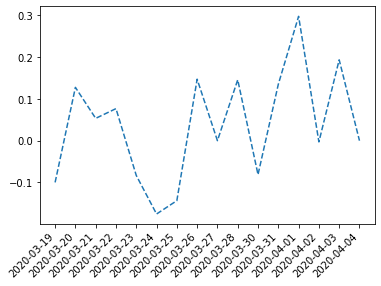

In [161]:
sa_tweet_df = UK_tweet_df
print(sa_tweet_df.shape)
sa_tweet_df = sa_tweet_df[sa_tweet_df.apply(lambda x: removal_nonwork_tweet(x['tweet'])==1, axis=1)]
print(sa_tweet_df.shape)
sa_Mean_df = sa_tweet_df
sa_Mean_df.Date = sa_Mean_df.Date.map(lambda x: str(x).split()[0])
sa_Mean_df = sa_Mean_df.groupby('Date')
Mean = sa_Mean_df['sentiment'].mean()
plt.plot(Mean,linestyle='--')
plt.xticks(rotation=45, ha='right')
plt.show()

## Hashtags

In [236]:
ht_tweet_df = pd.read_csv('englishtweet.csv')

In [237]:
ht_tweet_df = ht_tweet_df[~ht_tweet_df['hashtags'].isna()]

In [240]:
ht_tweet_df.hashtags.str.lower().value_counts()[:10]

corona                       1517
covid19                       608
coronavirus                   603
santrampalji_canendcorona     359
indiafightscorona             224
howtoend_coronapandemic       219
chinesevirus19                213
prabhas                       161
jantacurfew                   159
whocansave_the_world          136
Name: hashtags, dtype: int64

In [104]:
ht_US_tweet_df = US_tweet_df
ht_US_tweet_df = ht_US_tweet_df[~ht_US_tweet_df['hashtags'].isna()]
ht_US_tweet_df.hashtags.str.lower().value_counts()[:10]

corona            247
coronavirus       172
covid19           164
coronavirususa     43
covid_19           25
covidー19           22
trump              19
who                15
animalcrossing     14
medicareforall     14
Name: hashtags, dtype: int64

In [105]:
ht_UK_tweet_df = UK_tweet_df
ht_UK_tweet_df = ht_UK_tweet_df[~ht_UK_tweet_df['hashtags'].isna()]
ht_UK_tweet_df.hashtags.str.lower().value_counts()[:10]

corona                     18
coronavirus                13
covid19                    10
mohali                      2
howtoend_coronapandemic     2
stayhomesavelives           2
stayhome                    2
chinesevirus19              2
covid19pandemic             1
nullandvoid                 1
Name: hashtags, dtype: int64

In [107]:
ht_IN_tweet_df = IN_tweet_df
ht_IN_tweet_df = ht_IN_tweet_df[~ht_IN_tweet_df['hashtags'].isna()]
ht_IN_tweet_df.hashtags.str.lower().value_counts()[:10]

corona                       826
covid19                      259
indiafightscorona            216
coronavirus                  161
prabhas                      133
santrampalji_canendcorona    128
chinesevirus19                79
jantacurfew                   73
howtoend_coronapandemic       64
whocansave_the_world          54
Name: hashtags, dtype: int64

In [108]:
ht_NG_tweet_df = NG_tweet_df
ht_NG_tweet_df = ht_NG_tweet_df[~ht_NG_tweet_df['hashtags'].isna()]
ht_NG_tweet_df.hashtags.str.lower().value_counts()[:10]

chinesevirus19    46
covid19           42
corona            31
coronavirususa    22
coronavirus       20
covid_19          16
covid19nigeria    14
lockdown          13
airpeace          12
covidー19          12
Name: hashtags, dtype: int64

In [112]:
IN_tweet_df.shape

(17030, 6)